In [1]:
# # the traing set is original
import tensorflow as tf

import tensorflow_datasets as tfds
import os

2022-03-13 13:35:47.896569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 13:35:47.897020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATASETS_DIR = "/home/gen_model/dataset/logision_dataset/learning-datasets"
TRAIN_DATASETS_DIR = os.path.join(DATASETS_DIR, "training")
TEST_DATASETS_DIR = os.path.join(DATASETS_DIR, "testing")
FILENAME = ["good.txt","bad.txt"]

In [3]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

train_data_sets = []
test_data_sets = []

for i, file_name in enumerate(FILENAME):
    lines_dataset = tf.data.TextLineDataset(os.path.join(TRAIN_DATASETS_DIR, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    train_data_sets.append(labeled_dataset)

for i, file_name in enumerate(FILENAME):
    lines_dataset = tf.data.TextLineDataset(os.path.join(TEST_DATASETS_DIR, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    test_data_sets.append(labeled_dataset)

2022-03-13 13:35:59.285938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-13 13:35:59.286582: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-13 13:35:59.286788: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-4VN4G0C): /proc/driver/nvidia/version does not exist
2022-03-13 13:35:59.289798: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

In [5]:
train_data = train_data_sets[0]
for labeled_dataset in train_data_sets[1:]:
  train_data = train_data.concatenate(labeled_dataset)

test_data = test_data_sets[0]
for labeled_dataset in test_data_sets[1:]:
    test_data = test_data.concatenate(labeled_dataset)

train_data = train_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)
test_data = test_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False
)

In [6]:
train_dataset = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

2022-03-13 13:36:10.052411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9343 of 50000


texts:  [b'/niet1793285453.' b'/u4022352/' b'/000023911/']

labels:  [0 0 0]


2022-03-13 13:36:16.088896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [8]:
VOCAB_SIZE = 50000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

2022-03-13 13:36:26.959728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 17656 of 50000
2022-03-13 13:36:31.805608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [9]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,274,369
Trainable params: 3,274,369
Non-

In [10]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [11]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [12]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2022-03-13 13:39:19.684884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 18372 of 50000
2022-03-13 13:39:24.242145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


  20971/Unknown - 1020s 46ms/step - loss: 0.0654 - accuracy: 0.9718WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 30 batches). You may need to use the repeat() function when building your dataset.
20972/20972 [==============================] - 1029s 47ms/step - loss: 0.0654 - accuracy: 0.9718 - val_loss: 0.5089 - val_accuracy: 0.7240
Epoch 2/10


2022-03-13 13:56:00.195417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9811 of 50000


    2/20972 [..............................] - ETA: 34:32 - loss: 0.5257 - accuracy: 0.9922   

2022-03-13 13:56:06.285107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


20972/20972 [==============================] - 1071s 50ms/step - loss: 0.0496 - accuracy: 0.9753
Epoch 3/10


2022-03-13 14:13:51.763537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 17747 of 50000


    3/20972 [..............................] - ETA: 24:17 - loss: 0.4441 - accuracy: 1.0000  

2022-03-13 14:13:54.409636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


20972/20972 [==============================] - 1065s 50ms/step - loss: 0.0477 - accuracy: 0.9758
Epoch 4/10


2022-03-13 14:31:36.813799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7091 of 50000


    3/20972 [..............................] - ETA: 23:05 - loss: 0.4643 - accuracy: 0.9948  

2022-03-13 14:31:41.928482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


20972/20972 [==============================] - 1113s 52ms/step - loss: 0.0472 - accuracy: 0.9760
Epoch 5/10
20972/20972 [==============================] - 2285s 109ms/step - loss: 0.0471 - accuracy: 0.9760
Epoch 6/10
20972/20972 [==============================] - 1050s 50ms/step - loss: 0.0469 - accuracy: 0.9761
Epoch 7/10
20972/20972 [==============================] - 1049s 50ms/step - loss: 0.0466 - accuracy: 0.9761
Epoch 8/10
20972/20972 [==============================] - 3025s 144ms/step - loss: 0.0467 - accuracy: 0.9762
Epoch 9/10
20972/20972 [==============================] - 1000s 47ms/step - loss: 0.0467 - accuracy: 0.9762
Epoch 10/10


2022-03-13 17:10:19.239911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15815 of 50000


    2/20972 [..............................] - ETA: 26:22 - loss: 0.4243 - accuracy: 1.0000   

2022-03-13 17:10:24.456470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


20972/20972 [==============================] - 1040s 49ms/step - loss: 0.0465 - accuracy: 0.9762


In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


8/8 [==============================] - 1s 105ms/step - loss: 0.4826 - accuracy: 0.7360
Test Loss: 0.4826214909553528
Test Accuracy: 0.7360000014305115


(0.0, 0.5320633430033922)

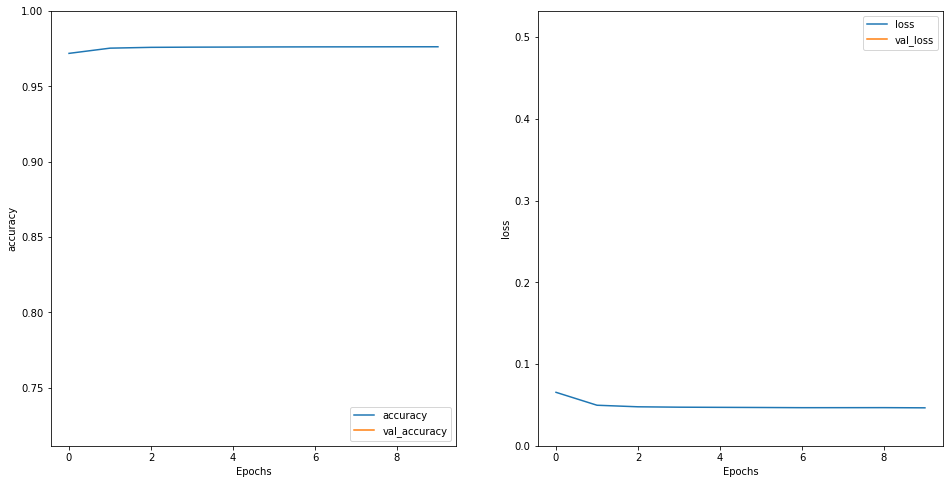

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [16]:
import numpy as np
sample_text = ("script alert(1) script")
predictions = model.predict(np.array([sample_text]))
predictions

array([[26.730742]], dtype=float32)